In [2]:
!pip install opencv-python
!pip install opencv-python-headless


Saving notes.png to notes.png
1024


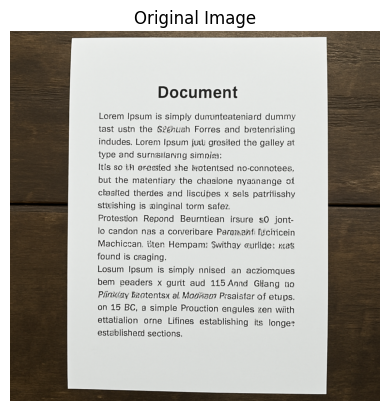

In [3]:
from google.colab import files
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

uploaded = files.upload()
image_path = list(uploaded.keys())[0]

image = cv2.imread(image_path)
orig = image.copy()

max_width = 1000
print(image.shape[1])
if image.shape[1] > max_width:
    image = cv2.resize(image, (max_width, int(image.shape[0] * max_width / image.shape[1])))

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

plt.axis('off')
plt.show()


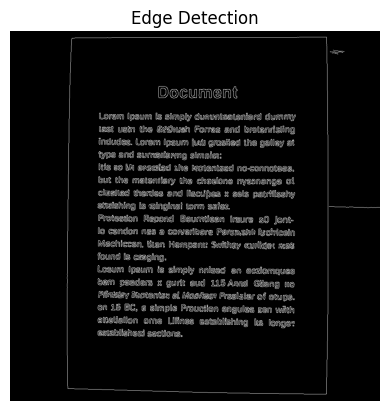

In [4]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 75, 200)

plt.imshow(edged, cmap='gray')
plt.title("Edge Detection")
plt.axis('off')
plt.show()


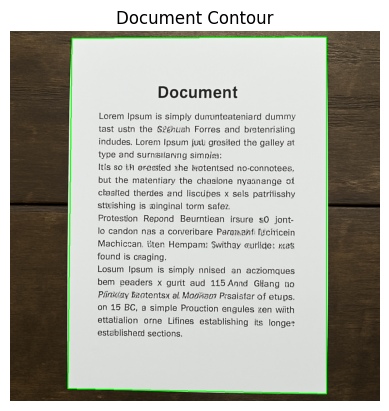

In [5]:
contours, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

doc_cnt = None

for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    if len(approx) == 4:
        doc_cnt = approx
        break

if doc_cnt is not None:
    cv2.drawContours(image, [doc_cnt], -1, (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Document Contour")
    plt.axis('off')
    plt.show()
else:
    print("Use a clear image")


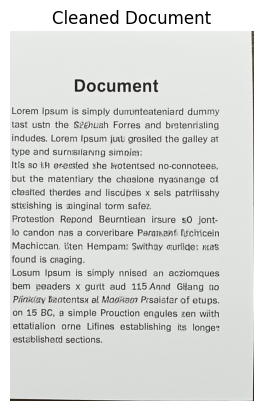

In [6]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(orig, M, (maxWidth, maxHeight))

    return warped

warped = four_point_transform(orig, doc_cnt.reshape(4, 2) * (orig.shape[1] / 700))
gray_warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
_, thresh_warped = cv2.threshold(gray_warped, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

contours, _ = cv2.findContours(thresh_warped, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
c = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(c)

cropped = warped[y:y+h, x:x+w]

plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
plt.title("Cleaned Document")
plt.axis('off')
plt.show()


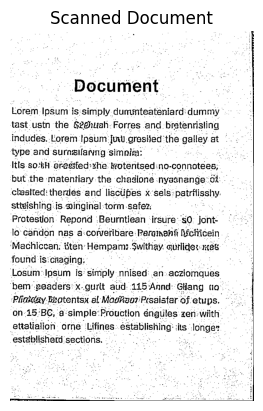

In [7]:
warped_gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
scanned = cv2.adaptiveThreshold(warped_gray, 255,
                                 cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 11, 2)

plt.imshow(scanned, cmap='gray')
plt.title("Scanned Document")
plt.axis('off')
plt.show()


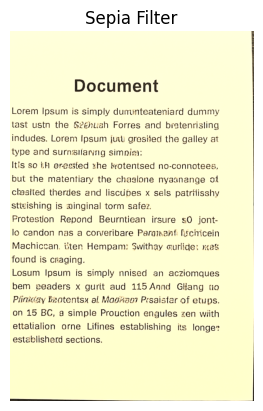

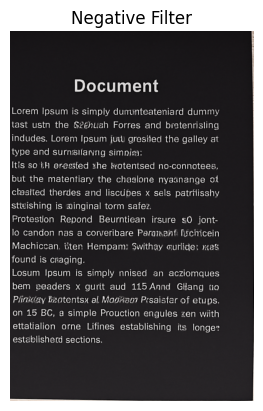

In [8]:
def sepia_filter(cropped):
    kernel = np.array([[0.393, 0.769, 0.189],
                       [0.349, 0.686, 0.168],
                       [0.272, 0.534, 0.131]])
    return cv2.transform(cropped, kernel)

filtered_image = sepia_filter(cropped)
plt.imshow(filtered_image)
plt.title("Sepia Filter")
plt.axis('off')
plt.show()

def negative_filter(cropped):
    return cv2.bitwise_not(cropped)

filtered_image3 = negative_filter(cropped)
plt.imshow(filtered_image3)
plt.title("Negative Filter")
plt.axis('off')
plt.show()


In [9]:
cv2.imwrite("scanned_output.png", scanned)
files.download("scanned_output.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>